<a href="https://colab.research.google.com/github/zixian0819/Applied-deep-learning/blob/master/sbdx1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A2: Image classification in the brower

In this assignment, you will gain real-world experience with image classification on small datasets - a common scenario in practice. There are three parts.

1. First, you will train a model on a small existing dataset.

2. Next,  you will collect a small dataset yourself. Of course, in practice there often isn’t  a dataset available for tasks you care about, so it’s valuable to get a feel for this process. You will train a small model from scratch, then use data augmentation to improve accuracy.

3. Finally, you will deploy your model from part two in a webpage using TensorFlow.js. A user will be able to upload a photo, and your model will classify it. 

## Instructions

Please complete this notebook by searching for **"TODO"**.

## Submission instructions

Please submit this assignment on CourseWorks by uploading a Jupyter notebook that includes saved output. If you are working in Colab, you can prepare your notebook for submission by ensuring that runs end-to-end, then saving and downloading it:

1. ```Runtime -> Restart and run all```
1. ```File -> Save```
1. ```File -> Download.ipynb```

Note: you will need to include a URL to your webpage for part 3, see the final TODO at the bottom of this notebook.

## Setup instructions
1. If you are running this notebook in Colab, make sure a GPU is enabled (```Edit -> Notebook settings -> Hardware accelerator```).

2. Create a GitHub Pages repo by following the instructions at https://pages.github.com/. You can use this to upload your webpage after getting it running locally.

In [0]:
try:
  %tensorflow_version 2.x # enable TF 2.x in Colab
except Exception:
  pass

`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `2.x # enable TF 2.x in Colab`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


In [0]:
import tensorflow as tf
print(tf.__version__)

2.1.0


## 1a) Flowers

In this part of the assignment, you will train a model on a small existing dataset (flowers).

In [0]:
import IPython.display as display
import matplotlib.pyplot as plt
import random
import time

from tensorflow.keras import datasets, layers, models

AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32
IMG_SIZE = 192
SHUFFLE_SIZE = 1000

### Download the flowers dataset

In [0]:
import pathlib
data_root_orig = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                         fname='flower_photos', untar=True)
data_root = pathlib.Path(data_root_orig)
print(data_root)

/root/.keras/datasets/flower_photos


### Write an input pipeline from scratch
There are several ways to load images in TensorFlow. Later in this assignment, you'll use the [Keras preprocessing utilities](https://keras.io/preprocessing/image/). For starters, though, you'll see how-to write your own using ```tf.data```, based on this [tutorial](https://www.tensorflow.org/beta/tutorials/load_data/images). This is valuable to do once (just so you can see how the nuts and bolts work) before using the higher level utils. This code is written for you as an example. Follow along and try to understand each piece.


In [0]:
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
image_count

3670

In [0]:
all_image_paths[:5]

['/root/.keras/datasets/flower_photos/daisy/18711159980_11d3bd5042.jpg',
 '/root/.keras/datasets/flower_photos/roses/4809566219_88f9a1aea3.jpg',
 '/root/.keras/datasets/flower_photos/sunflowers/19359539074_d7e32e6616_n.jpg',
 '/root/.keras/datasets/flower_photos/roses/8926641787_d2515dfe8f_m.jpg',
 '/root/.keras/datasets/flower_photos/tulips/470690620_9d3a5bb239.jpg']

### Get to know your data

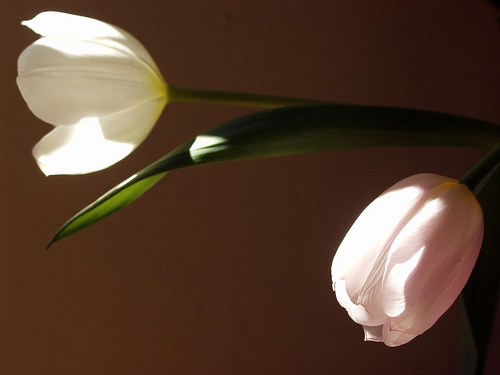

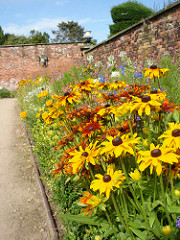

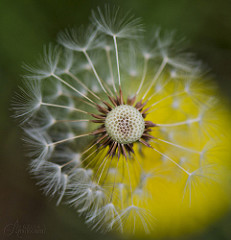

In [0]:
for n in range(3):
  image_path = random.choice(all_image_paths)
  display.display(display.Image(image_path))
  print()

### Classes are given by directory names

In [0]:
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [0]:
label_to_index = dict((name, index) for index, name in enumerate(label_names))
label_to_index

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

In [0]:
all_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths]

print("First 10 labels indices: ", all_labels[:10])

First 10 labels indices:  [0, 2, 3, 2, 4, 0, 1, 2, 1, 4]


### Create a train/test split

In [0]:
from sklearn.model_selection import train_test_split
train_paths, test_paths, train_labels, test_labels = train_test_split(all_image_paths, all_labels)   

### Display a few images and their labels

roses


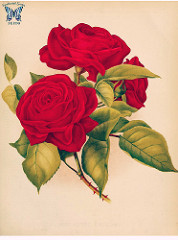


sunflowers


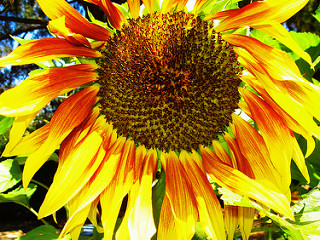


dandelion


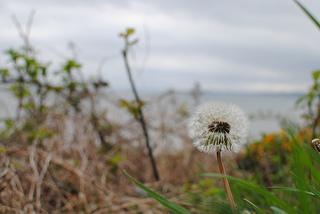

In [0]:
for n in range(3):
  i = random.randint(0,len(train_paths))
  image_path = train_paths[i]
  print(label_names[train_labels[i]])
  display.display(display.Image(image_path))
  print()

### Begin using TensorFlow ops to read and decode the images

In [0]:
img_raw = tf.io.read_file(train_paths[0])
print(repr(img_raw)[:100]+"...")

<tf.Tensor: shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00H\x00H\x...


In [0]:
img_tensor = tf.image.decode_image(img_raw)
print(img_tensor.shape)
print(img_tensor.dtype)

(281, 500, 3)
<dtype: 'uint8'>


In [0]:
img_final = tf.image.resize(img_tensor, [IMG_SIZE, IMG_SIZE])
img_final = img_final / 255.0 # normalize pixel values
print(img_final.shape)
print(img_final.numpy().min())
print(img_final.numpy().max())

(192, 192, 3)
0.049565367
1.0


### Wrap those in a function
Tip: pay careful attention to the preprocessing. When you deploy models in the browser, you will need to ensure that images are preprocessed identically in JavaScript as they are in Python.

In [0]:
def load_and_preprocess_image(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
  img /= 255.0  # normalize pixels to 0,1
  return img

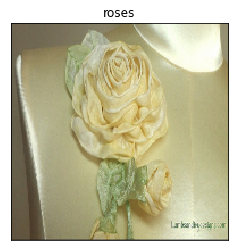

In [0]:
def show(img, label):
  plt.imshow(img)
  plt.title(label)
  plt.xticks([])
  plt.yticks([])
  print()

img_path = train_paths[0]
img = load_and_preprocess_image(img_path)
label = label_names[train_labels[0]]
show(img, label)

### Build an input pipeline to return images and labels
I realize this is complicated. The problem we're trying to solve using tf.data is performance (we want our preprocessing to run in C, but to write our code in Python). There are a bunch of advanced tricks you can do with tf.data as well (e.g. prefetching images to the GPU).

Note: although your *peak* performance can be higher, it's also very easy to make mistakes and end up with code that's super slow. Always benchmark your input pipelines before using them (shown in a bit). 

In [0]:
# a dataset that returns image paths
path_ds = tf.data.Dataset.from_tensor_slices(train_paths)
for n, img_path in enumerate(path_ds.take(4)):
  print(n, img_path)

0 tf.Tensor(b'/root/.keras/datasets/flower_photos/roses/8667101118_87ea757b15.jpg', shape=(), dtype=string)
1 tf.Tensor(b'/root/.keras/datasets/flower_photos/roses/22506717337_0fd63e53e9.jpg', shape=(), dtype=string)
2 tf.Tensor(b'/root/.keras/datasets/flower_photos/daisy/15029936576_8d6f96c72c_n.jpg', shape=(), dtype=string)
3 tf.Tensor(b'/root/.keras/datasets/flower_photos/sunflowers/21518663809_3d69f5b995_n.jpg', shape=(), dtype=string)


In [0]:
# a dataset that returns images (loaded off disk, decoded, and preprocessed)
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
for n, image in enumerate(image_ds.take(4)):
  print(n, image.shape)

0 (192, 192, 3)
1 (192, 192, 3)
2 (192, 192, 3)
3 (192, 192, 3)


In [0]:
# a dataset that returns labels
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(train_labels, tf.int64))
for label in label_ds.take(4):
  print(label_names[label.numpy()])

roses
roses
daisy
sunflowers


In [0]:
# a dataset that returns images and labels
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))
print(image_label_ds)

<ZipDataset shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int64)>


In [0]:
for img, label in image_label_ds.take(2):
  print(img.shape, label_names[label.numpy()])

(192, 192, 3) roses
(192, 192, 3) roses


### Batch and shuffle
Why do we need to specify a shuffle_size parameter? tf.data works with streams (it doesn't know their length). To shuffle items, we maintain an in-memory buffer of this size.

In [0]:
ds = image_label_ds.shuffle(SHUFFLE_SIZE)
ds = ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

for img, label in ds.take(2):
  print(img.shape, label.shape) # notice it's returning batches of data now

(32, 192, 192, 3) (32,)
(32, 192, 192, 3) (32,)


At this point, you could use the dataset above to train a model with ```model.fit(ds)``` but first, let's improve performance. As written, the dataset will load each image off disk, one at a time (super slow). Instead, we want to cache them in memory.

### Improve performance

In [0]:
# A benchmark utility to time how long it takes
# to iterate once over the entire dataset
def time_one_epoch(ds):
  start = time.time()
  batches = 0
  for i,(images,labels) in enumerate(ds):
    batches += 1
    if i % 10 == 0:
      print('.', end='')
  print()
  end = time.time()
  duration = end-start
  print("Read {} batches".format(batches))
  print("{:0.2f} Batches/s".format(batches/duration))
  print("{:0.2f} Images/s".format(BATCH_SIZE*batches/duration))
  print("Total time: {}s".format(duration))

### Use in-memory caching
This is a small dataset, so let's keep it in memory. The first time we iterate over this dataset, images will be loaded off disk, then cached. The first iteration will be quite slow, and subsequent ones will be faster. Let's show that. 

In [0]:
ds = image_label_ds.cache() # cache data in mempry
ds = ds.shuffle(SHUFFLE_SIZE)
ds = ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

In [0]:
time_one_epoch(ds) # this will be slow

.........
Read 86 batches
21.03 Batches/s
672.84 Images/s
Total time: 4.090121507644653s


Now that the cache is built, iteration will be much faster.

In [0]:
time_one_epoch(ds) # this will be fast

.........
Read 86 batches
235.83 Batches/s
7546.67 Images/s
Total time: 0.36466431617736816s


### How-to use on-disk caching

If the dataset did not fit into memory, you could use a cache file on disk, like this:

```
ds = image_label_ds.cache(filename='./cache.tf-data')
ds = ds.shuffle(buffer_size=BUFFER_SIZE)
ds = ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
```

This can be useful to perform expensive preprocessing only once, and/or to improve file I/O (TF saves the cache file in an efficient format - it can be faster to read one large file than a bunch of small ones). For now, we'll keep it in memory.

In [0]:
# here's our final training dataset
train_ds = image_label_ds.cache()
train_ds = train_ds.shuffle(SHUFFLE_SIZE)
train_ds = train_ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

# let's make a test dataset as well
path_ds = tf.data.Dataset.from_tensor_slices(test_paths)
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(test_labels, tf.int64))
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))
test_ds = image_label_ds.cache().batch(BATCH_SIZE)

### Finally, we have a fast pipeline ready to go, written from scratch
Now, let's define a model.

## 1b) Create a simple CNN
This is our baseline model, it will not be very accurate. You'll improve it below.

In [0]:
model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation='relu', 
                        input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(layers.MaxPooling2D())

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 190, 190, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 95, 95, 16)        0         
Total params: 448
Trainable params: 448
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.add(layers.Flatten())
model.add(layers.Dense(5, activation='softmax'))

### Tip: pay attention to the size of the model
Later, when you export a model to run in the webpage, you will want a small one (in terms of the number of parameters) that downloads quickly. Notice how much more efficient convolutional layers are than the dense layers (ask yourself,why?)

### Tip: pay attention to exactly how your images are preprocessed
Later, when you run your model in a browser, you'll need to preprocess images in JavaScript in exactly the same way.

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 190, 190, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 95, 95, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 144400)            0         
_________________________________________________________________
dense (Dense)                (None, 5)                 722005    
Total params: 722,453
Trainable params: 722,453
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
# I realize we're not using a separate test set, that's fine
# for this assignment
model.fit(train_ds, validation_data=test_ds, epochs=5)

Train for 86 steps, validate for 29 steps
Epoch 1/5
86/86 [==============================] - 13s 148ms/step - loss: 1.5871 - accuracy: 0.4455 - val_loss: 1.1360 - val_accuracy: 0.5338
Epoch 2/5
86/86 [==============================] - 2s 19ms/step - loss: 0.8802 - accuracy: 0.6784 - val_loss: 1.1401 - val_accuracy: 0.5392
Epoch 3/5
86/86 [==============================] - 2s 18ms/step - loss: 0.5128 - accuracy: 0.8434 - val_loss: 1.1715 - val_accuracy: 0.5632
Epoch 4/5
86/86 [==============================] - 2s 19ms/step - loss: 0.2800 - accuracy: 0.9342 - val_loss: 1.2895 - val_accuracy: 0.5294
Epoch 5/5
86/86 [==============================] - 2s 19ms/step - loss: 0.1504 - accuracy: 0.9727 - val_loss: 1.3212 - val_accuracy: 0.5425


### Make predictions on a single image
Tip: models are implemented to make predictions on batches of images for efficiency. This means that to make a prediction on a single image, you'll need to first wrap it in a batch. The syntax can feel a little unusual at first, but gets easier with time.

In [0]:
# load an image off disk
img_index = 0
img = load_and_preprocess_image(train_paths[img_index])

print(img.shape) # before

#########
## TODO: your code here
## use tf.expand_dims to create an empty batch dimension
## the starting image shape is (192, 192, 3)
## you want it to be (1, 192, 192, 3)
## that's read as "a batch of 1 image, with 192 rows, 192 cols, 
## and 3 color channels"
#########
im_batch =tf.expand_dims(img, 0)  # YOUR CODE HERE, use tf.expand_dims

print(im_batch.shape) # after

# make predictions
batch_pred = model.predict(im_batch) # returns a list of predictions
pred = batch_pred[0] 

print("Prediction", label_names[tf.argmax(pred)])
print("Actual", label_names[train_labels[img_index]])

(192, 192, 3)
(1, 192, 192, 3)
Prediction dandelion
Actual roses


### TODO: Improve accuracy
In the code cell below, write a new model that's more accurate than the baseline above. Define and train your model, and create plots of loss / accuracy as a function of epochs. Try to train your model to high accuracy, without overfitting. For this assignment, it is not necessary to build a super accurate model (just experiment a bit and try to improve over the baseline).

In [0]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu', 
                        input_shape=(IMG_SIZE, IMG_SIZE, 3)),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu', 
                        input_shape=(IMG_SIZE, IMG_SIZE, 3)),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),

  tf.keras.layers.Dense(128, activation = 'relu'),
  tf.keras.layers.Dense(64, activation = 'relu'),
  tf.keras.layers.Dense(32, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


model.fit(train_ds, validation_data=test_ds, epochs=5)

Train for 86 steps, validate for 29 steps
Epoch 1/5
86/86 [==============================] - 4s 50ms/step - loss: 1.7253 - accuracy: 0.3961 - val_loss: 1.2052 - val_accuracy: 0.5076
Epoch 2/5
86/86 [==============================] - 4s 41ms/step - loss: 0.9675 - accuracy: 0.6239 - val_loss: 1.0080 - val_accuracy: 0.6100
Epoch 3/5
86/86 [==============================] - 4s 41ms/step - loss: 0.6679 - accuracy: 0.7569 - val_loss: 1.1058 - val_accuracy: 0.5741
Epoch 4/5
86/86 [==============================] - 4s 41ms/step - loss: 0.3954 - accuracy: 0.8710 - val_loss: 1.1614 - val_accuracy: 0.6209
Epoch 5/5
86/86 [==============================] - 4s 41ms/step - loss: 0.1502 - accuracy: 0.9593 - val_loss: 1.6053 - val_accuracy: 0.6078


## 1c) Practice deploying your flowers classifier using TensorFlow.js
In the final part of the assignment, you'll export the model you build to recognize landmarks on Columbia's campus, and get it working in the browser. If you're new to JavaScript (as most of us are), the mechanics will be difficult at first. 

Let's practice by exporting your flowers classifier, and getting it working with TensorFlow.js (the starter code provided is written to work with flowers model).

### Save your model

In [0]:
model.save("/content/my_model.h5")

In [0]:
!ls -lha

total 199M
drwxr-xr-x 1 root root 4.0K Feb 20 01:54 .
drwxr-xr-x 1 root root 4.0K Feb 20 01:51 ..
drwxr-xr-x 1 root root 4.0K Feb 13 17:15 .config
-rw-r--r-- 1 root root 199M Feb 20 01:54 my_model.h5
drwxr-xr-x 1 root root 4.0K Feb  5 18:37 sample_data


### Download your saved model to your local machine

In [0]:
from google.colab import files
files.download("/content/my_model.h5")

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 60620, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 320, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 351, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 364, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 724, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil

### Visit notebook #2 (a2-2.ipynb on CourseWorks) to convert your saved model into to TensorFlow.js format

Follow the instructions there to prepare a webpage to run your flowers model in the browser. Once you have that working, you can continue with the rest of this assignment in this notebook.

## 1d) Classify flowers using transfer learning

In this part of the assignment, you'll use transfer learning to take advantage of a large pretrained model. It is not necesary to deploy this part in the browser.


Read this tutorial before completing this section:
* https://www.tensorflow.org/tutorials/images/transfer_learning

In [0]:
## TODO: your code here
# Choose a pretrained model, and import the application
# See https://keras.io/applications/ for a few choices
# When you import the model, you will want to remove the 
# final dense layer that performs classification (include_top=False)
# you will also want to import weights from ImageNet,
# and you will want to specify the input shape to match your images. 

base_model =  tf.keras.applications.MobileNetV2(input_shape=None,
                                               include_top=False,
                                               weights='imagenet')
# fix me. base_model = tf.keras.applications...

/tensorflow-2.1.0/python3.6/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


9412608/9406464 [==============================] - 1s 0us/step


In [0]:
# A hack to show you the output shape of the model
for image_batch, label_batch in train_ds.take(1):
   pass
  
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 6, 6, 1280)


In [0]:
# do not update the pretrained weights during training
# (we won't use finetuning here)
base_model.trainable = False 

In [0]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, None, None, 3 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, None, None, 3 128         Conv1[0][0]                      
_______________________________________________________________________________

In [0]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(5, activation='softmax')

In [0]:
# build a new model reusing the pretrained base
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [0]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
model.fit(train_ds, validation_data=test_ds, epochs=5)

Train for 86 steps, validate for 29 steps
Epoch 1/5
86/86 [==============================] - 150s 2s/step - loss: 0.9050 - accuracy: 0.6613 - val_loss: 0.9035 - val_accuracy: 0.6558
Epoch 2/5
86/86 [==============================] - 146s 2s/step - loss: 0.4811 - accuracy: 0.8328 - val_loss: 0.8965 - val_accuracy: 0.6710
Epoch 3/5
86/86 [==============================] - 146s 2s/step - loss: 0.4002 - accuracy: 0.8601 - val_loss: 0.9211 - val_accuracy: 0.6721
Epoch 4/5
86/86 [==============================] - 139s 2s/step - loss: 0.3481 - accuracy: 0.8859 - val_loss: 0.8001 - val_accuracy: 0.7168
Epoch 5/5
86/86 [==============================] - 135s 2s/step - loss: 0.3429 - accuracy: 0.8870 - val_loss: 0.8203 - val_accuracy: 0.7146


## 2a) Recognize landmarks on Columbia's campus

In this part of the assignment, you will train a model to recognize landmarks (famous places, like the [Alma Mater sculpture](https://en.wikipedia.org/wiki/Alma_Mater_(New_York_sculpture), or Butler library) on Columbia’s campus. Instead of tf.data, you will gain experience with the higher level Keras utilties. You will also experiment with data augmentation to increase the effective size of your dataset.

Starter code is not provided for this part of the assignment. You should base your work off the following Keras notebook, which works identically in TF2 (the only thing you'll need to change is the imports, an example of correct imports is given below).

* https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/5.2-using-convnets-with-small-datasets.ipynb

Here are steps you should complete.

1. Collect a dataset of at least three landmarks. Your dataset should include at least 50 images of each landmark in train, and 50 in validation (using more images is fine). Randomly shuffle your data to create these splits. You do not need to use a separate test set in this assignment.

 You will need to upload your dataset to Colab in order to train a model. To do so, you can either upload it using the file browser (slow and tedious, you'll need to repeat that if your runtime is reset), or (better) you can upload your dataset to Google Drive, then mount your drive as a filesystem in Colab (View -> Table of contents -> Code snippets -> search for "drive"). This will enable you to access the contents of your drive with commands like `!ls /gdrive`. As a another option, you could upload your dataset to a cloud provider or your Columbia account, then download it similarly to flowers at the top of this notebook.
 
1. Write a model to classify your data. Try to train a small model in terms of the number of parameters (you do not need to use transfer learning). 

1. Show predictions on several images.

1. Use data augmentation, see if this helps to improve accuracy.

1. Produce plots of accuracy / loss as a function of epochs. Determine the right place to stop training without overfitting.

When you have a reasonably accurate model, proceed to the next step. There are no guidelines for accuracy, try to build something you feel works well, given the small amount of data you have.

In [0]:

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os, shutil
# Example code showing the correct imports
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Example code:
# You should use the keras preprocessing utilities here instead of tf.data
# Here's an example of how to use them with the flowers dataset
# You will need to add data augmentation
# train_datagen = ImageDataGenerator(rescale=1./255)
# train_generator = train_datagen.flow_from_directory(
#         data_root,
#         target_size=(IMG_SIZE, IMG_SIZE),
#         batch_size=32)

# for data_batch, labels_batch in train_generator:
#     print('data batch shape:', data_batch.shape)
#     print('labels batch shape:', labels_batch.shape)
#     break

###
# The path to the directory where the original
# dataset was uncompressed
original_dataset_dir = '/content/drive/My Drive/landmarks'

# The directory where we will
# store our smaller dataset
base_dir = '/content/drive/My Drive/landmarks111'
os.mkdir(base_dir)

# Directories for our training,
# validation and test splits
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)


# Directory with our training pictures
train_Lion_dir = os.path.join(train_dir, 'Lion')
os.mkdir(train_Lion_dir)
train_Alma_dir = os.path.join(train_dir, 'Alma')
os.mkdir(train_Alma_dir)
train_Curl_dir = os.path.join(train_dir, 'Curl')
os.mkdir(train_Curl_dir)

# Directory with our validation pictures
validation_Lion_dir = os.path.join(validation_dir, 'Lion')
os.mkdir(validation_Lion_dir)
validation_Alma_dir = os.path.join(validation_dir, 'Alma')
os.mkdir(validation_Alma_dir)
validation_Curl_dir = os.path.join(validation_dir, 'Curl')
os.mkdir(validation_Curl_dir)


# list1 = []
# for i in range(100):
#   list1.append(i)
# randomnumber = random.sample(list1,50)

#Lion#
# Copy first 1000 cat images to train_cats_dir
fnames = ['Lion.{}.jpg'.format(i) for i in range(50)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_Lion_dir, fname)
    shutil.copyfile(src, dst)

# Copy next 500 cat images to validation_cats_dir
fnames = ['Lion.{}.jpg'.format(i) for i in range(50, 100) ]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_Lion_dir, fname)
    shutil.copyfile(src, dst)
    

#Alma#    
# Copy first 1000 dog images to train_dogs_dir
fnames = ['Alma.{}.jpg'.format(i) for i in range(50)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_Alma_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 500 dog images to validation_dogs_dir
fnames = ['Alma.{}.jpg'.format(i) for i in range(50, 100) ]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_Alma_dir, fname)
    shutil.copyfile(src, dst)
    
#Curl#
# Copy first 1000 dog images to train_dogs_dir
fnames = ['Curl.{}.jpg'.format(i) for i in range(50)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_Curl_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 500 dog images to validation_dogs_dir
fnames = ['Curl.{}.jpg'.format(i) for i in range(50, 100) ]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_Curl_dir, fname)
    shutil.copyfile(src, dst)
    



In [0]:
print('total training Lion images:', len(os.listdir(train_Lion_dir)))

total training Lion images: 50


In [0]:
print('total training Alma images:', len(os.listdir(train_Alma_dir)))

total training Alma images: 50


In [0]:
print('total training Curl images:', len(os.listdir(train_Curl_dir)))

total training Curl images: 50


In [0]:
print('total validation Lion images:', len(os.listdir(validation_Lion_dir)))

total validation Lion images: 50


In [0]:
print('total validation Alma images:', len(os.listdir(validation_Alma_dir)))

total validation Alma images: 50


In [0]:
print('total validation Curl images:', len(os.listdir(validation_Curl_dir)))

total validation Curl images: 50


In [0]:
#Building networks
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras import layers
from tensorflow.keras import models
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(192, 192, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
# model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))



In [0]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 190, 190, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 95, 95, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 93, 93, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 44, 44, 128)       73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 22, 22, 128)       0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 61952)            

In [0]:
from tensorflow.keras import optimizers
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
import keras
keras.__version__

'2.2.5'

In [0]:
from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        target_size=(192, 192),
        batch_size=32)

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(192, 192),
        batch_size=32)

for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

Found 150 images belonging to 3 classes.
Found 150 images belonging to 3 classes.
data batch shape: (32, 192, 192, 3)
labels batch shape: (32, 3)


In [0]:

history = model.fit(
      train_generator,
      epochs=10,
      validation_data=validation_generator)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5 steps, validate for 5 steps
Epoch 1/10
5/5 [==============================] - 59s 12s/step - loss: 1.8169 - accuracy: 0.4067 - val_loss: 1.0185 - val_accuracy: 0.3333
Epoch 2/10
5/5 [==============================] - 57s 11s/step - loss: 0.9153 - accuracy: 0.7333 - val_loss: 0.6375 - val_accuracy: 0.9000
Epoch 3/10
5/5 [==============================] - 57s 11s/step - loss: 0.4449 - accuracy: 0.8200 - val_loss: 0.2353 - val_accuracy: 0.9733
Epoch 4/10
5/5 [==============================] - 56s 11s/step - loss: 0.1292 - accuracy: 0.9867 - val_loss: 0.0417 - val_accuracy: 1.0000
Epoch 5/10
5/5 [==============================] - 56s 11s/step - loss: 0.0188 - accuracy: 1.0000 - val_loss: 6.7524e-04 - val_accuracy: 1.0000
Epoch 6/10
5/5 [==============================] - 56s 11s/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 1.2779e-04 - val_accuracy: 1.0000
Epoch 7/10
5/5 [==============================] - 56s 11s/step - los

In [0]:
model.save('Columbia_landmarks.h5')

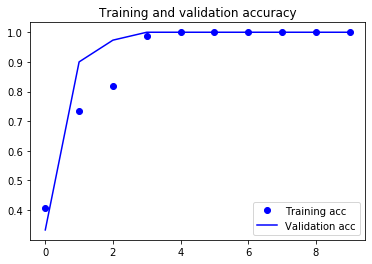

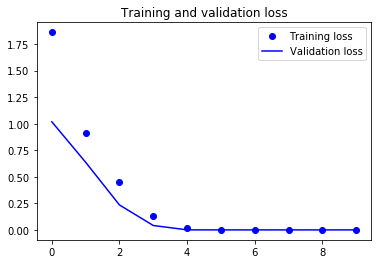

In [0]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
#Building networks
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras import layers
from tensorflow.keras import models
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(192, 192, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
# model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)
validation_datagen = ImageDataGenerator(rescale=1./255)

# Note that the validation data should not be augmented!

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(192, 192),
        batch_size=32)
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(192, 192),
        batch_size=32)

for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

Found 150 images belonging to 3 classes.
Found 150 images belonging to 3 classes.
data batch shape: (32, 192, 192, 3)
labels batch shape: (32, 3)


In [0]:
history = model.fit(
      train_generator,
      epochs=10,
      validation_data=validation_generator)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5 steps, validate for 5 steps
Epoch 1/10
5/5 [==============================] - 60s 12s/step - loss: 2.2660 - accuracy: 0.3733 - val_loss: 1.0842 - val_accuracy: 0.3333
Epoch 2/10
5/5 [==============================] - 59s 12s/step - loss: 1.0686 - accuracy: 0.3733 - val_loss: 1.0059 - val_accuracy: 0.3333
Epoch 3/10
5/5 [==============================] - 59s 12s/step - loss: 0.9709 - accuracy: 0.3533 - val_loss: 0.8081 - val_accuracy: 0.4200
Epoch 4/10
5/5 [==============================] - 59s 12s/step - loss: 0.8486 - accuracy: 0.4933 - val_loss: 0.7330 - val_accuracy: 0.4400
Epoch 5/10
5/5 [==============================] - 59s 12s/step - loss: 0.6169 - accuracy: 0.7667 - val_loss: 0.4277 - val_accuracy: 0.7667
Epoch 6/10
5/5 [==============================] - 59s 12s/step - loss: 0.3775 - accuracy: 0.9200 - val_loss: 0.1743 - val_accuracy: 1.0000
Epoch 7/10
5/5 [==============================] - 59s 12s/step - loss: 0.305

In [0]:
model.save('Columbia_landmarks_2.h5')

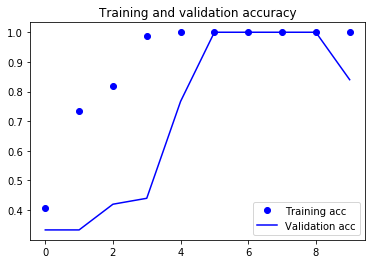

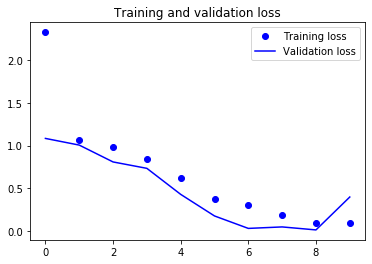

In [0]:
accuracy = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## 2b) Run your model in the browser
Save and download your model, and head to notebook two again. After you've finished creating a webpage, upload it to GitHub Pages (or your Columbia account), list the URL here, save your assignment, and submit your assignment. You may not need to make many changes to the starter code, but pay attention to the preprocessing, number of output classes, image size, etc.

In [0]:
# TODO: list your URL here. 
# If you are unable to get it working in GitHub pages, you can also 
# submit a screenshot of your model running locally in a browser for
# partial credit.
# http://your_webpage